In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.optimize import line_search

#### Consider the Rosenbrock function:
$$f(x) = (1-x)^2 + 100(y-x^2)^2$$
#### which has the global minima at (1,1)

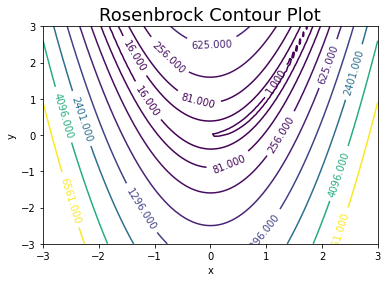

In [2]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = (1-X)**2 + 100*(Y-X**2)**2

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(6)
cp = ax.contour(x,y,Z, np.arange(10)**4)
ax.clabel(cp, inline=True, 
          fontsize=10)
ax.set_title('Rosenbrock Contour Plot', fontsize = 18)
ax.set_xlabel('x')
ax.set_ylabel('y')
# plt.figure(figsize=(100,80))
plt.show()

In [138]:
#Rosenbrock
def rosenb_f(x):
    f = (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
    return f

def grad_rosenb(x):
    fx = -2 + 2*x[0] + 400*x[0]**3 - 400*x[0]*x[1]
    fy = 200*(x[1] - x[0]**2)
    return np.array([fx,fy])

def hessian_rosenb(x):
    fxx = 2 + 1200*x[0]**2 -400*x[1]
    fxy = -400*x[0]
    fyx = -400*x[0]
    fyy = 200
    return np.array([[fxx,fxy], [fyx, fyy]])

In [4]:
def is_pd(x):
    return np.all(np.linalg.eigvals(x)>0)

In [140]:
def Steepest_Descent(xk, pk, epsilon, alpha, rho, c1, func, der_func, hess_func):
    k=0
    stepLengths_SD = []
    obj_func_SD = []
    x_iterates_SD = []
    x_iterates_SD.append(xk)
    while LA.norm(pk) > epsilon:
        obj_func_SD.append(func(xk))
        alpha = 1
#         print('k:',k)
        pk = -der_func(xk)
        #Backtracking line search
        while func(xk + alpha*pk) >= func(xk) + c1*alpha*np.dot(pk.reshape(2,1).T,der_func(xk).reshape(2,1))[0][0]:
            alpha = rho*alpha
        xk = xk + alpha*pk
        x_iterates_SD.append(xk)
        k = k+1
        stepLengths_SD.append(alpha)
    
    x_iterates_SD = np.array(x_iterates_SD)
    
    sd_dict = {}
    sd_dict['stepLengths'] = stepLengths_SD
    sd_dict['obj_func'] = obj_func_SD
    sd_dict['x_iterates'] = x_iterates_SD
    sd_dict['k'] = k
    return sd_dict

In [243]:
def Newtons_Method(xk, pk, epsilon, alpha, rho, c1, func, der_func, hess_func):
    k=0
    max_iter = 1000
    stepLengths_N = []
    obj_func_N = []
    pk = -LA.inv(hess_func(xk)).dot(der_func(xk))
    x_iterates_N = []
    x_iterates_N.append(xk)
    while LA.norm(pk) > epsilon and k<max_iter:
#         print('k:', k)
        obj_func_N.append(func(xk))
        alpha = 1
        pk = -LA.inv(hess_func(xk)).dot(der_func(xk))
        #Backtracking line search
        while func(xk + alpha*pk) > func(xk) + c1*alpha*np.dot(pk.T,der_func(xk).reshape(2,1)):
            alpha = rho*alpha
        xk = xk + alpha*pk
        x_iterates_N.append(xk)
        k = k+1
        stepLengths_N.append(alpha)
    
    x_iterates_N = np.array(x_iterates_N)
    
    n_dict = {}
    n_dict['stepLengths'] = stepLengths_N
    n_dict['obj_func'] = obj_func_N
    n_dict['x_iterates'] = x_iterates_N
    n_dict['k'] = k
    return n_dict

In [194]:
def BFGS(x0, epsilon, H0, c1, c2, rho, func, der_func, hess_func):
    stepLengths_bfgs = []
    obj_func_bfgs = []
    #Grad fk
    dfk = der_func(x0)
    Hk = H0
    pk = -Hk.dot(dfk)
    k=0
    xk = x0
    x_iterates_bfgs = []
    pd = []
    x_iterates_bfgs.append(xk)
    err_hess = []
    while LA.norm(dfk) > epsilon:
        obj_func_bfgs.append(func(xk))
        pk = -Hk.dot(dfk)
        
        #Line search
        alpha = 1
        alpha = line_search(func, der_func, xk, pk)[0]
        
        xk_new = xk + alpha*pk
        x_iterates_bfgs.append(xk_new)
        dfk = der_func(xk_new)
        sk = xk_new - xk
        yk = der_func(xk_new) - der_func(xk)
        rho_k = 1/np.dot(yk.T, sk)
        
        
        Hk = (np.identity(2) - rho_k*np.outer(sk, yk))@Hk@(np.identity(2)
                                                           - rho_k*np.outer(yk, sk)) + rho_k*np.outer(sk, sk)
        
        err_hess.append(LA.norm(LA.inv(Hk)-hess_func(xk_new)))
        pd.append(is_pd(Hk))
        xk = xk_new
        
        k = k+1
        stepLengths_bfgs.append(alpha)
        
    x_iterates_bfgs = np.array(x_iterates_bfgs)
    
    bfgs_dict = {}
    bfgs_dict['stepLengths'] = stepLengths_bfgs
    bfgs_dict['obj_func'] = obj_func_bfgs
    bfgs_dict['x_iterates'] = x_iterates_bfgs
    bfgs_dict['k'] = k
    bfgs_dict['pd'] = pd
    bfgs_dict['err_hess'] = err_hess
    return bfgs_dict

In [196]:
#Starting points
x01 = np.array([2.5,2.5])
x02 = np.array([-1.2,-1])
# x03 = np.array([-1.5, 1.5])
xk = np.array([x01, x02])

epsilon = 1e-5
pk1 = -grad_rosenb(x01).reshape(2,1)
pk2 = -grad_rosenb(x02).reshape(2,1)

alpha = 1
rho = 0.4
c1 = 1e-4

#SD
sd_dict1 = Steepest_Descent(x01, pk1, epsilon, alpha, rho, c1, rosenb_f, grad_rosenb, hessian_rosenb)
sd_dict2 = Steepest_Descent(x02, pk2, epsilon, alpha, rho, c1, rosenb_f, grad_rosenb, hessian_rosenb)

#NM
n_dict1 = Newtons_Method(x01, pk1, epsilon, alpha, rho, c1, rosenb_f, grad_rosenb, hessian_rosenb)
n_dict2 = Newtons_Method(x02, pk2, epsilon, alpha, rho, c1, rosenb_f, grad_rosenb, hessian_rosenb)

#BFGS
alpha = 1
rho = 0.4
c1 = 1e-4
c2 = 0.9
epsilon = 1e-5
H0 = (1/np.linalg.norm(grad_rosenb(x01)))*np.eye(x01.shape[0])
bfgs_dict1 = BFGS(x01, epsilon, H0, c1, c2, rho, rosenb_f, grad_rosenb, hessian_rosenb)

H0 = (1/np.linalg.norm(grad_rosenb(x02)))*np.eye(x01.shape[0])
bfgs_dict2 = BFGS(x02, epsilon, H0, c1, c2, rho, rosenb_f, grad_rosenb, hessian_rosenb)

print('Starting point: ', (x01[0], x01[1]))
print('Gradient descent method, #iterations:', sd_dict1['k'])
print('Newton method, #iterations:', n_dict1['k'])
print('BFGS, #iterations:', bfgs_dict1['k'])
print('\n')


print('Starting point: ', (x02[0], x02[1]))
print('Gradient descent method, #iterations:', sd_dict2['k'])
print('Newton method, #iterations:', n_dict2['k'])
print('BFGS, #iterations:', bfgs_dict2['k'])
print('\n')

sd_dict_list = []
sd_dict_list.append(sd_dict1)
sd_dict_list.append(sd_dict2)

n_dict_list = []
n_dict_list.append(n_dict1)
n_dict_list.append(n_dict2)

bfgs_dict_list = []
bfgs_dict_list.append(bfgs_dict1)
bfgs_dict_list.append(bfgs_dict2)

Starting point:  (2.5, 2.5)
Gradient descent method, #iterations: 9775
Newton method, #iterations: 18
BFGS, #iterations: 30


Starting point:  (-1.2, -1.0)
Gradient descent method, #iterations: 10107
Newton method, #iterations: 22
BFGS, #iterations: 27




In [105]:
def plot_traj(dict_list, method_name):
    xx1 = dict_list[0]['x_iterates']
    xx2 = dict_list[1]['x_iterates']

    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 7, 100)
    X, Y = np.meshgrid(x, y)
    Z = (1-X)**2 + 100*(Y-X**2)**2
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(14)
    cp = ax.contour(X,Y,Z, np.arange(2,10)**4)

    ax.plot(xx1[:,0],xx1[:,1], '-o', color='red', markersize=7)
    ax.plot(xx2[:,0],xx2[:,1], '-o', color='blue', markersize=7)
    ax.plot(xx1[-1,0],xx1[-1,1], '-o', color='black', markersize=15)
    ax.annotate('converging point at[1,1]',
                xy=(1, 1.1), xycoords='data',
                xytext=(-15, 25), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='bottom',fontsize = 12)

    ax.annotate('initial point at[2.5,2.5]',
                xy=(2.5, 2.5), xycoords='data',
                xytext=(-15, 25), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='bottom',fontsize = 12)
    ax.annotate('initial point at[-1.2,-1]',
                xy=(-1.2, -1), xycoords='data',
                xytext=(-1.2, 25), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='bottom',fontsize = 12)
    
    ax.set_title('Convergence of '+ method_name+' for different initial points', fontsize = 18,fontweight='bold')
    ax.set_xlabel('X',fontsize=16,fontweight='bold')
    ax.set_ylabel('Y',fontsize=16,fontweight='bold')
    plt.show()

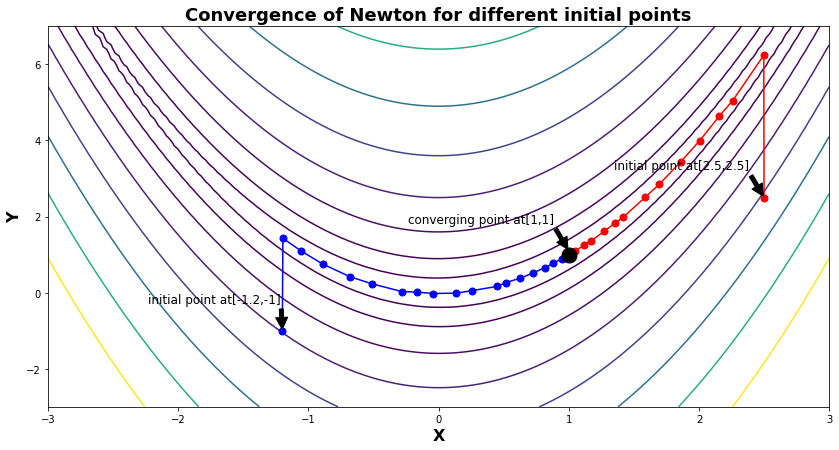

In [106]:
plot_traj(n_dict_list, 'Newton')

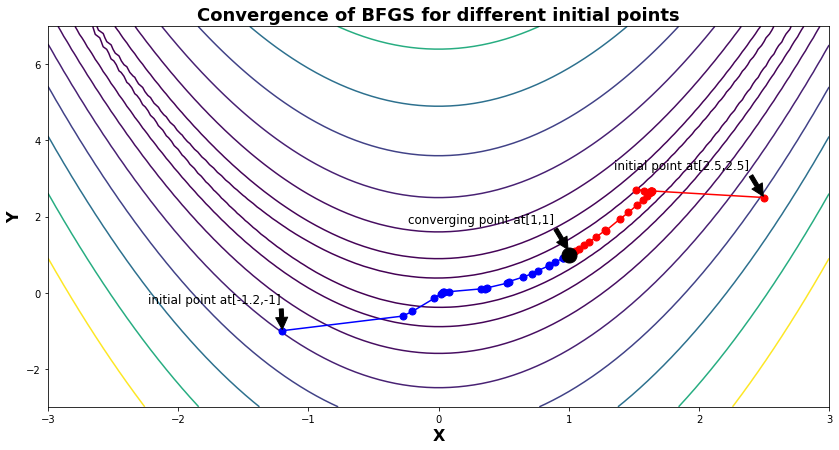

In [107]:
plot_traj(bfgs_dict_list, 'BFGS')

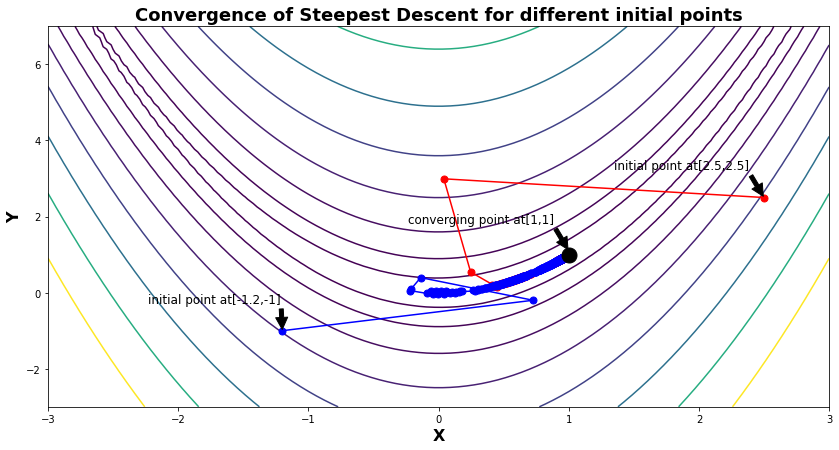

In [108]:
plot_traj(sd_dict_list,'Steepest Descent')

In [ ]:
def Himmer(x):
    return (x[0]**2 + x[1] - 11)**2 + ( x[0] + x[1]**2 - 7 )**2

def Grad_Himmer(x):
    return np.array([2 * (-7 + x[0] + x[1]**2 + 2 * x[0] * (-11 + x[0]**2 + x[1])), 2 * (-11 + x[0]**2 + x[1] + 2 * x[1] * (-7 + x[0] + x[1]**2))])

def Hessian_Himmer(x):
    h11 = 4 * (x[0]**2 + x[1] - 11) + 8 * x[0]**2 + 2
    h12 = 4 * x[0] + 4 * x[1]
    h21 = 4 * x[0] + 4 * x[1]
    h22 = 4 * (x[0] + x[1]**2 - 7) + 8 * x[1]**2 + 2
    
    return np.array([[h11,h12],[h21,h22]]) 

#### Consider the Himmerblau function:
$$f(x) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$
#### which has four identical local minima at

$$ f(3,2) = 0$$
$$ f(-2.805, 3.131) = 0$$
$$ f(-3.779, -3.28) = 0$$
$$ f(3.584,  -1.848) = 0$$

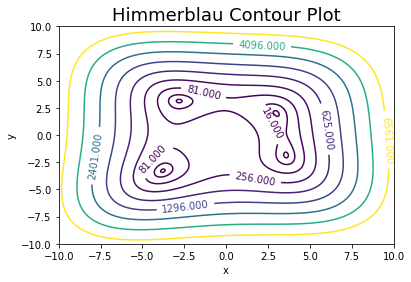

In [235]:
x = np.linspace(-10, 10, 500)
y = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(x, y)
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(6)
cp = ax.contour(x,y,Z, np.arange(10)**4)
ax.clabel(cp, inline=True, 
          fontsize=10)
ax.set_title('Himmerblau Contour Plot', fontsize = 18)
ax.set_xlabel('x')
ax.set_ylabel('y')
# plt.figure(figsize=(100,80))
plt.show()

In [258]:
#Starting points
x01 = np.array([0.5,-2])
# x02 = np.array([-1.2,-1])
# x03 = np.array([-1.5, 1.5])
xk = np.array([x01, x02])

epsilon = 1e-5
pk1 = -grad_rosenb(x01).reshape(2,1)
pk2 = -grad_rosenb(x02).reshape(2,1)
# pk3 = -grad_rosenb(x03).reshape(2,1)

alpha = 1
rho = 0.4
c1 = 1e-4

#NM
n_dict1 = Newtons_Method(x01, pk1, epsilon, alpha, rho, c1, Himmer, Grad_Himmer, Hessian_Himmer)

#BFGS
alpha = 1
rho = 0.4
c1 = 1e-4
c2 = 0.9
epsilon = 1e-5
H0 = (1/np.linalg.norm(grad_rosenb(x01)))*np.eye(x01.shape[0])
bfgs_dict1 = BFGS(x01, epsilon, H0, c1, c2, rho, Himmer, Grad_Himmer, Hessian_Himmer)


print('Starting point: ', (x01[0], x01[1]))
print('Newton method, #iterations:' + str(n_dict1['k']) + ', converging point:' + str(n_dict1['x_iterates'][-1]))
print('BFGS, #iterations:' + str(bfgs_dict1['k']) + ', converging point:' + str(bfgs_dict1['x_iterates'][-1]))
print('\n')

n_dict_list = []
n_dict_list.append(n_dict1)

bfgs_dict_list = []
bfgs_dict_list.append(bfgs_dict1)

Starting point:  (0.5, -2.0)
Newton method, #iterations:1000, converging point:[ 0.5 -2. ]
BFGS, #iterations:10, converging point:[ 3.58442834 -1.84812653]




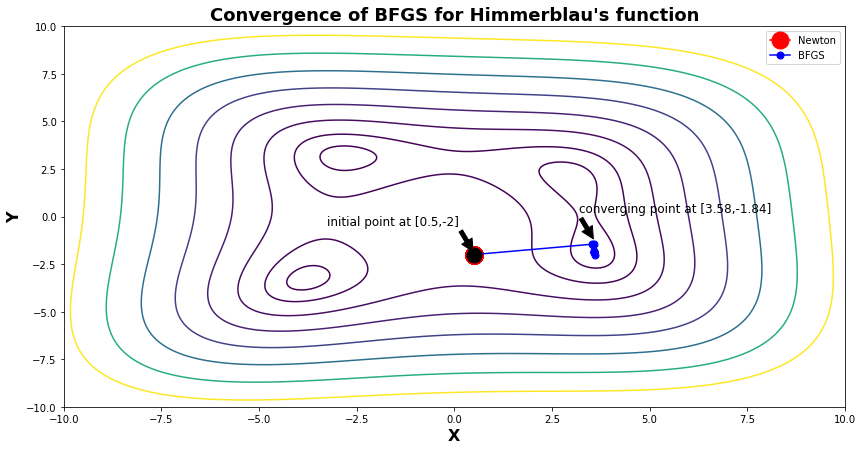

In [290]:
xx1 = n_dict1['x_iterates']
xx2 = bfgs_dict1['x_iterates']

x = np.linspace(-10, 10, 500)
y = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(x, y)
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(14)
cp = ax.contour(X,Y,Z, np.arange(2,10)**4)

ax.plot(xx1[:,0],xx1[:,1], '-o', color='red', markersize=17, label='Newton')
ax.plot(xx2[:,0],xx2[:,1], '-o', color='blue', markersize=7, label='BFGS')
ax.plot(xx1[-1,0],xx1[-1,1], '-o', color='black', markersize=15)

ax.annotate('converging point at [3.58,-1.84]',
            xy=(3.58,-1.24), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',fontsize = 12)

ax.annotate('initial point at [0.5,-2]',
            xy=(0.5, -1.9), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 12)

ax.set_title('Convergence of BFGS for Himmerblau\'s function', fontsize = 18,fontweight='bold')
ax.set_xlabel('X',fontsize=16,fontweight='bold')
ax.set_ylabel('Y',fontsize=16,fontweight='bold')
ax.legend()
plt.show()